# Auto-encoders
![picture](https://drive.google.com/uc?export=view&id=1grXLk_-HpWr9ZOjjZbDdAwUyuTUIbT4i)



* CNN Based Deep learning networks
* Input and Output is an image
* Used to generate a new image from the input
* Used for image to image transform
































# CNN Based Auto-encoder architecture:

![picture](https://drive.google.com/uc?export=view&id=1zuAGK_vy90elBo4rW3m6SfOJn88Ow-Vm)

Contains three parts:

*  The encoder - CNN+ Downsampling
*  Latent Space Representation
*  The Decoder - CNN+ Upsampling


# Applications:
1. Image Compression
2. Image Denosing
3. Image Segmantation
4. Image style transfer

# 1. Image Compression


![picture](https://drive.google.com/uc?export=view&id=1ZQFNV53US04jtcMaj4rtMT0lWMGPsSEG)

* The input and output is same
* Latent space represntation is the compressed code

# 2. Image Denosing

![picture](https://drive.google.com/uc?export=view&id=1VI5s8LWWm01rFyY6cYz9u_6WM-WQbq3G)

* Input is noisy image and outout is the denoised image

# 3. Image Segmantation


![picture](https://drive.google.com/uc?export=view&id=11qfsi987hauZZvhHlZPves0pT8wRgTNp)

* Create the semantic segmnetation of the image

# 4. Image Style transfer

![picture](https://drive.google.com/uc?export=view&id=15IO7XJtSp5qmN7X_zgdwQ9tsyia8sPR8)

* Gray Images  to RGB 
* Hardly used
* Better networks - Variational autoencoders, GAN Based Networks 

In this notebook we will create an auto-encoder based model for image colorization (Gray to RGB)

In [ ]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

## Mount the google drive 
![picture](https://drive.google.com/uc?export=view&id=12NI3Nqrl4fwF3yMBMKAKwRsXlTVLxY-6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data 
Here the data is loaded from folder in the google drive using the default Keras function 

```
# flow_from_directory
```



In [ ]:
path = '/content/drive/My Drive/Autoencoders/Gray-to-RGB/dataset/'
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(256, 256),batch_size=210,class_mode=None)

Found 210 images belonging to 1 classes.


#Print the size of the dataset

In [ ]:
train[0].shape

(210, 256, 256, 3)

# Create the training images

Here we split the image into Lab color space:
![picture](https://drive.google.com/uc?export=view&id=1AAEKwGgjzkvRQKtOnrUsOzylAsmAU54q)



*  L- gray part 
*  ab- color part 

**L** - is the gray image used for training \\
**ab** - is the output we need to generate from L using autoencoder




In [ ]:
X =[] #For training
Y =[] # Ground truth for training
for img in train[0]:
  lab = rgb2lab(img)
  X.append(lab[:,:,0])
  Y.append(lab[:,:,1:] / 128)
 
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(210, 256, 256, 1)
(210, 256, 256, 2)


# Plot the training data

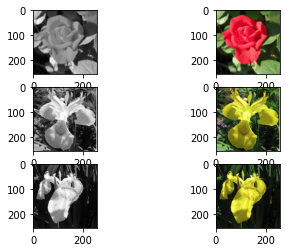

In [ ]:
for i in range(3):
  plt.subplot(3,2,2*i+1)
  plt. imshow(X[i].reshape(256,256),cmap="gray")
  colorimage = np.zeros((256, 256, 3))
  colorimage[:,:,0] = X[i].reshape(256,256)
  colorimage[:,:,1:] = Y[i]*128
  plt.subplot(3,2,2*i+2)
  plt.imshow(lab2rgb(colorimage))


# The network
![picture](https://drive.google.com/uc?export=view&id=18HzfkIcq940bWEcNWIs9j0PhGUsRdvBP)

Here we introduce two new layers:

1.   Upsampling
2.   Activation: tanh



# Upsampling Layer
To reconstruct the image in decoder portion we use Upsampling Layer
```
UpSampling2D((2, 2),interpolation="nearest")
```
![picture](https://drive.google.com/uc?export=view&id=1S12XMrTWtPhVq8lj5OfcE0IWOGZZW36u)

#Activation function: tanh()
Output is mapped b/w -1 and +1
![picture](https://drive.google.com/uc?export=view&id=1L3P8VAz3XcfBKM-rfo9NaFZrOkkq2rm3)





In [ ]:
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)      

# Loss function and optimizer

Here the loss function is **mean square error (mse)**
![picture](https://drive.google.com/uc?export=view&id=1ZZge1QNp89s8MywcUg37HiyPZXZyk6ec)

In [ ]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.fit(X,Y,validation_split=0.2, epochs=10 )

Epoch 1/10


#Save the model
![picture](https://drive.google.com/uc?export=view&id=1SG51U01t_tp6jkEkm68s5MhD6mu_mSIc)

In [ ]:
model.save('/content/drive/My Drive/Autoencoders/gray2rgbmodel2')

NameError: ignored

#Load the test images
, then covert them into Lab format

1.   Load the color images
2.   Covert them into Lab colorspace - rgb2lab
3.   Take the 'L' image as test case
4. Normalize the image
5. Shape the image into : (3,256,256,1)



In [ ]:

test_path = '/content/drive/My Drive/Autoencoders/Gray-to-RGB/dataset/flower_images/'
test = os.listdir(test_path)
color_me = []
imag = []
for imgName in test[0:3]:
  img = img_to_array(load_img(test_path + imgName))
  imag.append(load_img(test_path + imgName))
  img = resize(img ,(256,256))
  color_me.append(img)
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
print(color_me.shape)



(3, 256, 256, 1)


# Load the trained Model and predict

In [ ]:
trainedModel = keras.models.load_model('/content/drive/My Drive/Autoencoders/gray2rgbmodel')
output = trainedModel.predict(color_me)
output = output * 128


# Display the result

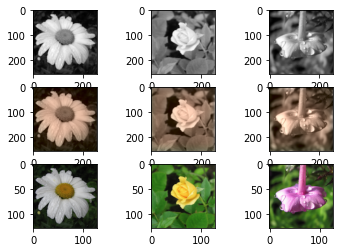

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(output)):
    result = np.zeros((256, 256, 3))
    result[:,:,0] = color_me[i][:,:,0]
    result[:,:,1:] = output[i]
    #img = np.array(result, dtype=np.uint8)
    subplot = plt.subplot(3,3,i+1)
    plt.imshow(color_me[i].reshape(256,256))
    plt.gray()
    subplot = plt.subplot(3,3,i+4)
    plt.imshow(lab2rgb(result))
    subplot = plt.subplot(3,3,i+7)
    plt.imshow(imag[i])


